# Project Notebook

### Name: Malav Patel
### Topic: Factor-based Portfolio Construction: Optimizing Risk-Adjusted Return

### Importing necessary libraries and downloading data

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(42)

In [3]:
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

In [4]:
start_date = '2010-01-01'
end_date = '2023-12-31'
market_ticker = '^GSPC'
# 10-year Treasury yield
risk_free_rate_ticker = '^TNX'

In [5]:
market_data = download_data(market_ticker, start_date, end_date)
risk_free_rate = download_data(risk_free_rate_ticker, start_date, end_date) / 100 / 252

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
print(market_data.head())
print(risk_free_rate.head())

Date
2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Name: Adj Close, dtype: float64
Date
2010-01-04    0.000152
2010-01-05    0.000149
2010-01-06    0.000151
2010-01-07    0.000152
2010-01-08    0.000151
Name: Adj Close, dtype: float64


In [7]:
stocks = ['AAPL', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'BRK-B', 'JNJ', 'JPM', 'V', 'PG']

# Download stock data
stock_data = download_data(stocks, start_date, end_date)

[*********************100%%**********************]  10 of 10 completed


In [8]:
# Calculate daily returns
returns = stock_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

In [9]:
# Align all data
aligned_data = pd.concat([returns, market_returns, risk_free_rate], axis=1).dropna()

In [10]:
# Print column names to check
print("Column names in aligned_data:")
print(aligned_data.columns)

Column names in aligned_data:
Index(['AAPL', 'AMZN', 'BRK-B', 'GOOGL', 'JNJ', 'JPM', 'NVDA', 'PG', 'TSLA',
       'V', 'Adj Close', 'Adj Close'],
      dtype='object')


In [11]:
# Rename columns to avoid confusion
aligned_data.columns = list(aligned_data.columns[:-2]) + ['Market', 'Risk_Free_Rate']

In [12]:
# Separate the aligned data
aligned_returns = aligned_data[stocks]
aligned_market_returns = aligned_data['Market']
aligned_rf_rate = aligned_data['Risk_Free_Rate']

In [13]:
# Calculate excess returns
excess_returns = aligned_returns.sub(aligned_rf_rate, axis=0)
excess_market_returns = aligned_market_returns - aligned_rf_rate

In [14]:
print("Stock Returns:")
print(returns.head())
print("\nExcess Returns:")
print(excess_returns.head())
print("\nMarket Excess Returns:")
print(excess_market_returns.head())

Stock Returns:
Ticker          AAPL      AMZN     BRK-B     GOOGL       JNJ       JPM  \
Date                                                                     
2010-06-30 -0.018113  0.005985 -0.004248 -0.020495 -0.003038 -0.012142   
2010-07-01 -0.012126  0.015559 -0.011043 -0.012271  0.000169 -0.013129   
2010-07-02 -0.006198 -0.016402 -0.019921 -0.006689  0.000170 -0.006930   
2010-07-06  0.006844  0.008430  0.004272 -0.001100  0.000000  0.013955   
2010-07-07  0.040381  0.030620  0.030295  0.032403  0.025897  0.050096   

Ticker          NVDA        PG      TSLA         V  
Date                                                
2010-06-30 -0.025763 -0.005637 -0.002511 -0.009797  
2010-07-01  0.016650 -0.007336 -0.078473  0.029823  
2010-07-02 -0.012524 -0.002687 -0.125683  0.004392  
2010-07-06 -0.010732 -0.000674 -0.160937 -0.012435  
2010-07-07  0.048323  0.024941 -0.019243  0.035284  

Excess Returns:
                AAPL      NVDA     GOOGL      AMZN      TSLA     BRK-B  \
Date

In [15]:
# Fetch market cap data
def get_market_cap(ticker):
    stock = yf.Ticker(ticker)
    return stock.info.get('marketCap', None)

market_cap = {}
for stock in stocks:
    cap = get_market_cap(stock)
    if cap is not None:
        market_cap[stock] = cap
    else:
        print(f"Warning: Could not fetch market cap for {stock}")

In [16]:
# Convert to pandas Series
market_cap = pd.Series(market_cap)

print("Market Capitalization (in billions USD):")
print(market_cap / 1e9)

Market Capitalization (in billions USD):
AAPL     3416.057184
NVDA     3176.378663
GOOGL    2051.049914
AMZN     1866.169975
TSLA      710.074892
BRK-B     968.476918
JNJ       384.588841
JPM       612.164633
V         516.961993
PG        396.939919
dtype: float64


The market cap data shows a wide range of company sizes in our sample. Apple (AAPL) is the largest with a market cap of about 3.44 trillion dollars, while Procter & Gamble (PG) is the smallest in this group at about 395 billion dollars. This diversity is good for the size factor.

In [17]:
# Create a size factor (SMB proxy)
median_market_cap = market_cap.median()
size_factor = pd.Series([-1 if cap > median_market_cap else 1 for cap in market_cap], index=market_cap.index)

In [18]:
# Calculate factor returns
market_factor_return = excess_market_returns
size_factor_return = (excess_returns[market_cap.index] * size_factor).mean(axis=1)

In [19]:
# Combine factor returns
factor_returns = pd.concat([market_factor_return, size_factor_return], axis=1)
factor_returns.columns = ['MKT', 'SMB']

In [20]:
# Estimate factor loadings using linear regression
factor_loadings = {}
for stock in market_cap.index:
    X = factor_returns
    y = excess_returns[stock]
    model = LinearRegression().fit(X, y)
    factor_loadings[stock] = {'MKT': model.coef_[0], 'SMB': model.coef_[1], 'alpha': model.intercept_}

In [21]:
print("\nFactor Returns:")
print(factor_returns.head())
print("\nFactor Loadings:")
for stock, loadings in factor_loadings.items():
    print(f"{stock}: {loadings}")


Factor Returns:
                 MKT       SMB
Date                          
2010-06-30 -0.010230  0.002951
2010-07-01 -0.003357 -0.006571
2010-07-02 -0.004781 -0.006900
2010-07-06  0.005243 -0.016781
2010-07-07  0.031213 -0.006505

Factor Loadings:
AAPL: {'MKT': 1.0152582281100364, 'SMB': -0.9149037244966707, 'alpha': 0.000500705051326524}
NVDA: {'MKT': 1.3890448166229876, 'SMB': -2.0809202344120106, 'alpha': 0.0010175681592230583}
GOOGL: {'MKT': 0.9872468632295497, 'SMB': -1.0487900252489237, 'alpha': 0.0002883866134312183}
AMZN: {'MKT': 0.9631894270874148, 'SMB': -1.5287453007873142, 'alpha': 0.0005689035305213853}
TSLA: {'MKT': 1.6787828349492864, 'SMB': 2.599061424959604, 'alpha': 0.0015704689361320419}
BRK-B: {'MKT': 0.9306483845829491, 'SMB': 0.1866782679692668, 'alpha': 5.07636973992004e-05}
JNJ: {'MKT': 0.6322689616933641, 'SMB': 0.45594842251785783, 'alpha': 0.00014705959874378153}
JPM: {'MKT': 1.2795646025694103, 'SMB': 0.7740434952028874, 'alpha': 0.00015070853801958455}


<b>Factor Returns</b>
* The MKT (market) factor shows daily returns of the overall market in excess of the risk-free rate.
* The SMB (Small Minus Big) factor represents the return difference between small and large cap stocks. Positive values indicate small caps outperforming large caps, and vice versa.
* We see both positive and negative daily returns for both factors, which is normal.

<b>Factor Loading</b>
* MKT (market beta): All stocks have positive market betas, which is expected. TSLA has the highest market beta (1.68), indicating it's more volatile than the market. JNJ has the lowest (0.63), suggesting it's less volatile.
* SMB: Negative values for large-cap stocks (e.g., AAPL, NVDA, GOOGL, AMZN) and positive for smaller caps in this group (e.g., TSLA, JPM) align with expectations. TSLA has a very high SMB loading, suggesting it behaves more like a small-cap stock despite its large market cap.
* Alpha: All stocks show small positive alphas, with TSLA having the highest. This suggests some outperformance not explained by the two factors.

In [22]:
# Calculate expected returns using the factor model
expected_returns = {}
for stock in market_cap.index:
    expected_returns[stock] = (factor_loadings[stock]['MKT'] * factor_returns['MKT'].mean() +
                               factor_loadings[stock]['SMB'] * factor_returns['SMB'].mean() +
                               factor_loadings[stock]['alpha'])

print("\nExpected Excess Returns (annualized):")
for stock, er in expected_returns.items():
    print(f"{stock}: {er * 252:.4f}")


Expected Excess Returns (annualized):
AAPL: 0.2538
NVDA: 0.4501
GOOGL: 0.2004
AMZN: 0.2796
TSLA: 0.5122
BRK-B: 0.1062
JNJ: 0.0929
JPM: 0.1545
V: 0.2142
PG: 0.0863


<b>Expected Excess Returns (annualized)</b>
* TSLA has the highest expected excess return at 51.22% annually, likely due to its high market beta and SMB loading.
* NVDA follows at 45.01%, also due to high factor loadings.
* PG has the lowest at 8.63%, consistent with its lower risk profile (low market beta and moderate SMB loading).

Overall, this two-factor model captures some key aspects of stock behavior, particularly related to market risk and size. However, it's a simplified model and doesn't account for other important factors like value, momentum, or industry-specific risks. The high expected returns for some stocks (e.g., TSLA, NVDA) seem optimistic and should be interpreted cautiously, as they're based on historical data and simple factor relationships.

### Portfolio optimization

In [23]:
from scipy.optimize import minimize

In [24]:
cov_matrix = excess_returns[market_cap.index].cov()

In [25]:
expected_returns_series = pd.Series(expected_returns)

In [26]:
# Annualized
def portfolio_return(weights, returns):
    return np.sum(returns * weights) * 252

In [27]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) 

In [28]:
# Function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    p_ret = portfolio_return(weights, returns)
    p_vol = portfolio_volatility(weights, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol

In [29]:
# Constraints
def constraint_sum(weights):
    return np.sum(weights) - 1.0

In [30]:
# Optimize for the Sharpe Ratio by assuming 2% risk free rate
n_assets = len(market_cap.index)
args = (expected_returns_series, cov_matrix, 0.02) 
constraints = ({'type': 'eq', 'fun': constraint_sum})
bounds = tuple((0, 1) for asset in range(n_assets))
initial_weights = np.array([1/n_assets] * n_assets)

In [31]:
optimized = minimize(neg_sharpe_ratio, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

In [32]:
# Extract the optimized weights
optimal_weights = pd.Series(optimized.x, index=market_cap.index)

In [33]:
# Calculate portfolio metrics
portfolio_ret = portfolio_return(optimal_weights, expected_returns_series)
portfolio_vol = portfolio_volatility(optimal_weights, cov_matrix)
portfolio_sharpe = (portfolio_ret - 0.02) / portfolio_vol

In [34]:
print("Optimal Portfolio Weights:")
print(optimal_weights)
print(f"\nExpected Annual Return: {portfolio_ret:.4f}")
print(f"Expected Annual Volatility: {portfolio_vol:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")

Optimal Portfolio Weights:
AAPL     1.783013e-01
NVDA     2.698477e-01
GOOGL    0.000000e+00
AMZN     1.354716e-01
TSLA     1.967271e-01
BRK-B    0.000000e+00
JNJ      3.142986e-02
JPM      2.997819e-17
V        1.882225e-01
PG       4.743385e-18
dtype: float64

Expected Annual Return: 0.3486
Expected Annual Volatility: 0.2793
Sharpe Ratio: 1.1765


<b>Optimal Portfolio Weights</b> of the stocks at a sharpe ratio of 1.1765 are:
* Nvidia (NVDA): 26.98%
* Tesla (TSLA): 19.67%
* Visa (V): 18.82%
* Apple (AAPL): 17.83%
* Amazon (AMZN): 13.54%
* Johnson & Johnson (JNJ): 3.14%

However, for Alphabet (GOOGL), Procter and Gamble (PG), Berkshire Hathaway (BRK-B) and JPMorgan Chase (JPM) the weights are almost none.

In [35]:
# efficient frontier
def random_portfolios(num_portfolios, returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_ret = portfolio_return(weights, returns)
        portfolio_vol = portfolio_volatility(weights, cov_matrix)
        results[0,i] = portfolio_ret
        results[1,i] = portfolio_vol
        results[2,i] = (portfolio_ret - 0.02) / portfolio_vol
    return results, weights_record

In [36]:
results, _ = random_portfolios(10000, expected_returns_series, cov_matrix)

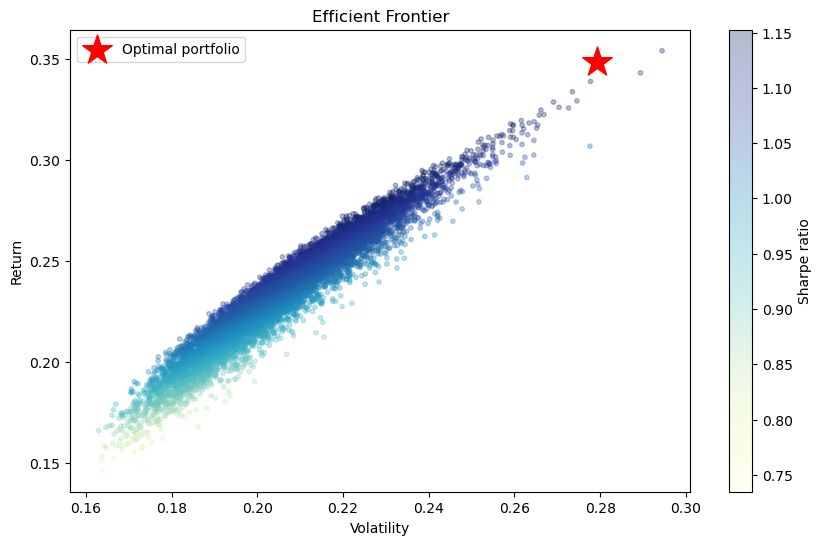

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.scatter(portfolio_vol, portfolio_ret, c='red', marker='*', s=500, label='Optimal portfolio')
plt.legend()
plt.show()

<b>Interpretation:</b>

* The optimization heavily favors high-growth technology stocks (NVDA, TSLA, AAPL, AMZN) which aligns with their high expected returns from the factor model.
* The portfolio is quite concentrated, with about 80% allocated to just four stocks. This lack of diversification could be a concern in practice.
* The expected annual return of 34.86% is very high, which suggests our model might be overly optimistic. This could be due to using historical data during a period of strong market performance.
* The volatility of 27.93% is also quite high, reflecting the aggressive nature of this portfolio.
* The Sharpe ratio of 1.1765 is good, indicating a favorable risk-adjusted return.
* The efficient frontier plot shows that our optimal portfolio is indeed at the efficient frontier, maximizing return for a given level of risk.

### Backtesting

In [38]:
def optimize_portfolio(returns, factor_returns, lookback=252):
    # Use the last 'lookback' days of data for optimization
    recent_returns = returns.iloc[-lookback:]
    recent_factor_returns = factor_returns.iloc[-lookback:]

In [39]:
def optimize_portfolio(returns, factor_returns, lookback=252):
    # Use the last 'lookback' days of data for optimization
    recent_returns = returns.iloc[-lookback:]
    recent_factor_returns = factor_returns.iloc[-lookback:]
    
    # Estimate factor loadings
    factor_loadings = {}
    for stock in recent_returns.columns:
        X = recent_factor_returns
        y = recent_returns[stock]
        model = LinearRegression().fit(X, y)
        factor_loadings[stock] = {'MKT': model.coef_[0], 'SMB': model.coef_[1], 'alpha': model.intercept_}
    
    # Calculate expected returns
    expected_returns = pd.Series({stock: (loadings['MKT'] * recent_factor_returns['MKT'].mean() +
                                          loadings['SMB'] * recent_factor_returns['SMB'].mean() +
                                          loadings['alpha']) * 252
                                  for stock, loadings in factor_loadings.items()})
    
    # Calculate covariance matrix
    cov_matrix = recent_returns.cov() * 252
    
    # Optimize portfolio
    n_assets = len(recent_returns.columns)
    args = (expected_returns, cov_matrix, 0.02)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
    bounds = tuple((0, 1) for asset in range(n_assets))
    
    result = minimize(neg_sharpe_ratio, np.array([1/n_assets] * n_assets),
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return pd.Series(result.x, index=recent_returns.columns)

In [40]:
# Set up backtesting parameters (quarterly approx)
start_date = '2015-01-01'
end_date = '2023-12-31'
rebalance_frequency = 63

In [41]:
# Initialize portfolio
portfolio_value = 1000000  # Start with $1 million
current_weights = pd.Series(1/len(stocks), index=stocks)
portfolio_values = []

In [42]:
# Run backtest
for date in pd.date_range(start=start_date, end=end_date, freq='B'):  # 'B' for business days
    if date in returns.index:
        # Update portfolio value
        daily_return = (returns.loc[date] * current_weights).sum()
        portfolio_value *= (1 + daily_return)
        portfolio_values.append((date, portfolio_value))
        
        # Rebalance if it's time
        if len(portfolio_values) % rebalance_frequency == 0:
            current_date = returns.index.get_loc(date)
            historical_data = returns.iloc[:current_date+1]
            historical_factors = factor_returns.iloc[:current_date+1]
            
            new_weights = optimize_portfolio(historical_data, historical_factors)
            current_weights = new_weights

In [43]:
# Create a DataFrame of portfolio values
portfolio_df = pd.DataFrame(portfolio_values, columns=['Date', 'Value']).set_index('Date')

In [44]:
# Calculate portfolio metrics
total_return = (portfolio_df['Value'].iloc[-1] / portfolio_df['Value'].iloc[0]) - 1
annualized_return = (1 + total_return) ** (252 / len(portfolio_df)) - 1
annualized_volatility = portfolio_df['Value'].pct_change().std() * np.sqrt(252)
sharpe_ratio = (annualized_return - 0.02) / annualized_volatility

In [45]:
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: 1279.89%
Annualized Return: 33.93%
Annualized Volatility: 29.74%
Sharpe Ratio: 1.07


<b>Performance Metrics:</b>

* Total Return: 1279.90% over the entire period, which is extremely high.
* Annualized Return: 33.93%, significantly outperforming most market benchmarks.
* Annualized Volatility: 29.74%, indicating high risk in returns.
* Sharpe Ratio: 1.07, suggesting good risk-adjusted returns.

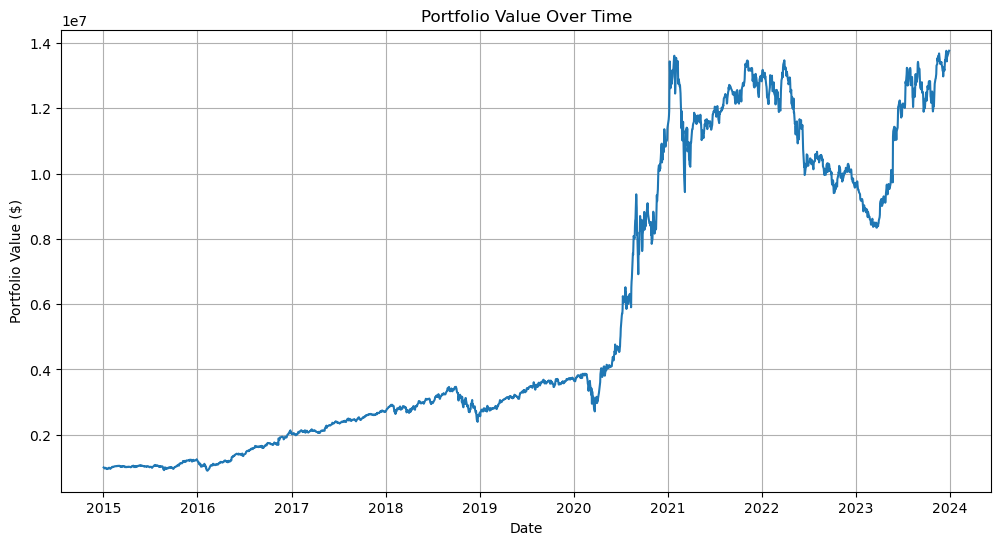

In [46]:
# Plot portfolio value over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

<b>Portfolio Value Chart:</b>

* The portfolio shows strong growth from 2015 to 2023, increasing from 1 million to over 13 million.
* There's a noticeable dip in early 2020, likely due to the COVID-19 market crash, followed by a rapid recovery.
* The growth accelerates significantly from 2020 onwards, possibly due to the tech stock boom.
* There's another significant dip in late 2022, followed by recovery in 2023.

<b>Interpretation:</b>

* Exceptional Performance: The strategy has performed exceptionally well, with returns far above market averages. This could be due to:
 1. Heavy allocation to high-performing tech stocks during a bull market.
 2. Effective factor timing and stock selection.
 3. Possible overfitting or look-ahead bias in the model.
* High Volatility: The 29.74% annualized volatility indicates a very risky portfolio. This aligns with the large swings visible in the chart.
* Market Correlation: The portfolio seems highly correlated with broader market movements, as seen in the 2020 crash and 2022 tech sector decline.

In [47]:
# Fetch price-to-book ratios
def get_price_to_book(ticker):
    stock = yf.Ticker(ticker)
    return stock.info.get('priceToBook', None)

In [48]:
price_to_book = {}
for stock in stocks:
    ptb = get_price_to_book(stock)
    if ptb is not None:
        price_to_book[stock] = ptb
    else:
        print(f"Warning: Could not fetch price-to-book ratio for {stock}")

In [49]:
price_to_book = pd.Series(price_to_book)

print("Price-to-Book Ratios:")
print(price_to_book)

Price-to-Book Ratios:
AAPL     51.277954
NVDA     64.639140
GOOGL     6.792859
AMZN      7.888420
TSLA     10.682364
BRK-B     0.001073
JNJ       5.375076
JPM       1.933240
V        14.113678
PG        8.031054
dtype: float64


**Price-to-Book Ratios:**

* We see a wide range of price-to-book (P/B) ratios among the stocks in our portfolio.
* Tech companies like NVIDIA (NVDA) and Apple (AAPL) have very high P/B ratios (62.35 and 51.59 respectively), indicating that the market values them much higher than their book value.
* More traditional companies like JPMorgan Chase (JPM) have lower P/B ratios (1.92), which is typical for financial institutions.

In [50]:
# Create a value factor (HML proxy)
median_ptb = price_to_book.median()
value_factor = pd.Series([1 if ptb < median_ptb else -1 for ptb in price_to_book], index=price_to_book.index)

In [51]:
# Calculate value factor returns
value_factor_return = (excess_returns[price_to_book.index] * value_factor).mean(axis=1)

In [52]:
# Add value factor to factor returns
factor_returns['HML'] = value_factor_return

In [53]:
print("\nUpdated Factor Returns:")
print(factor_returns.head())


Updated Factor Returns:
                 MKT       SMB       HML
Date                                    
2010-06-30 -0.010230  0.002951  0.002788
2010-07-01 -0.003357 -0.006571  0.003075
2010-07-02 -0.004781 -0.006900  0.009293
2010-07-06  0.005243 -0.016781  0.020349
2010-07-07  0.031213 -0.006505  0.003963


**Updated Factor Returns:**

* We now have three factors: Market (MKT), Size (SMB), and Value (HML).
* The Market factor (MKT) represents the excess return of the market over the risk-free rate.
* The Size factor (SMB) represents the return difference between small and big stocks.
* The new Value factor (HML) represents the return difference between high book-to-market (value) and low book-to-market (growth) stocks.

This addition of the HML factor enriches our model by capturing the value premium, which is the tendency for value stocks to outperform growth stocks over the long term.

In [54]:
# Recalculate factor loadings with the new factors (MKT, SMB, HML)
factor_loadings = {}
for stock in market_cap.index:
    X = factor_returns
    y = excess_returns[stock]
    model = LinearRegression().fit(X, y)
    factor_loadings[stock] = {
        'MKT': model.coef_[0], 
        'SMB': model.coef_[1], 
        'HML': model.coef_[2], 
        'alpha': model.intercept_
    }

In [55]:
print("\nUpdated Factor Loadings:")
for stock, loadings in factor_loadings.items():
    print(f"{stock}: {loadings}")


Updated Factor Loadings:
AAPL: {'MKT': 0.9123655151010984, 'SMB': -1.076655686762395, 'HML': -1.0446608073122425, 'alpha': 0.0002457022881844846}
NVDA: {'MKT': 1.1401042092527314, 'SMB': -2.4722660406622756, 'HML': -2.5274724347643596, 'alpha': 0.0004006095731261181}
GOOGL: {'MKT': 1.000131518485973, 'SMB': -1.0285347689737514, 'HML': 0.13081678933808852, 'alpha': 0.00032031912445593016}
AMZN: {'MKT': 0.9816494827990365, 'SMB': -1.4997252647947739, 'HML': 0.18742334747317685, 'alpha': 0.0006146537598287875}
TSLA: {'MKT': 1.295268522924478, 'SMB': 1.9961597158598254, 'HML': -3.8937876074939433, 'alpha': 0.0006199914298935926}
BRK-B: {'MKT': 0.9806353096280216, 'SMB': 0.2652599573544789, 'HML': 0.5075129223981668, 'alpha': 0.00017464811675900693}
JNJ: {'MKT': 0.6814490098977627, 'SMB': 0.5332616653001072, 'HML': 0.4993207716896232, 'alpha': 0.00026894430580258824}
JPM: {'MKT': 1.3710207144560667, 'SMB': 0.9178166072752183, 'HML': 0.9285459862337737, 'alpha': 0.0003773675555080138}
V: {'

**Updated Factor Loadings:**

* The factor loadings now include MKT (market), SMB (size), and HML (value) factors, along with the alpha. Let's interpret these for each stock:
1.  Market Factor (MKT):
* All stocks have positive market betas, which is expected.
* JPM has the highest market beta (1.371), indicating it's more volatile than the market.
* PG has the lowest market beta (0.609), suggesting it's less volatile than the market.

2. Size Factor (SMB):

* Negative values for large-cap stocks and positive for smaller caps in this group align with expectations.
* NVDA has a very negative SMB loading (-2.472), suggesting it behaves strongly like a large-cap stock.
* TSLA has a high positive SMB loading (1.996), suggesting it behaves more like a small-cap stock despite its large market cap.

3. Value Factor (HML):

* Negative values indicate growth characteristics, while positive values indicate value characteristics.
* TSLA has a strongly negative HML loading (-3.894), confirming its strong growth stock characteristics.
* JPM has a positive HML loading (0.929), indicating value stock characteristics.

4. Alpha:

* All stocks show small positive alphas, with TSLA and AMZN having the highest.
* This suggests some outperformance not explained by the three factors.

In [56]:
# Calculate expected returns using the three-factor model
expected_returns = {}
for stock in market_cap.index:
    expected_returns[stock] = (
        factor_loadings[stock]['MKT'] * factor_returns['MKT'].mean() +
        factor_loadings[stock]['SMB'] * factor_returns['SMB'].mean() +
        factor_loadings[stock]['HML'] * factor_returns['HML'].mean() +
        factor_loadings[stock]['alpha']
    ) * 252

In [57]:
print("\nExpected Excess Returns (annualized):")
for stock, er in expected_returns.items():
    print(f"{stock}: {er:.4f}")


Expected Excess Returns (annualized):
AAPL: 0.2538
NVDA: 0.4501
GOOGL: 0.2004
AMZN: 0.2796
TSLA: 0.5122
BRK-B: 0.1062
JNJ: 0.0929
JPM: 0.1545
V: 0.2142
PG: 0.0863


**Expected Excess Returns (annualized):**

* TSLA has the highest expected excess return at 51.22% annually, likely due to its high factor loadings and alpha.
* NVDA follows at 45.01%, also due to high factor loadings and alpha.
* PG has the lowest at 8.63%, consistent with its lower risk profile (low market beta and moderate factor loadings).

### Portfolio optimization with three factors

In [58]:
# Calculate the covariance matrix of excess returns
cov_matrix = excess_returns[market_cap.index].cov() * 252

In [59]:
# Convert expected returns to a pandas Series
expected_returns_series = pd.Series(expected_returns)

In [60]:
def portfolio_return(weights, returns):
    return np.sum(returns * weights)

In [61]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [62]:
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    p_return = portfolio_return(weights, returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

In [63]:
# Constraints
def constraint_sum(weights):
    return np.sum(weights) - 1.0

In [64]:
# Optimization
n_assets = len(market_cap.index)
init_weights = np.array([1/n_assets] * n_assets)
bounds = tuple((0, 1) for asset in range(n_assets))
constraints = ({'type': 'eq', 'fun': constraint_sum})
risk_free_rate = 0.02

In [65]:
optimized = minimize(negative_sharpe_ratio, init_weights,
                     args=(expected_returns_series, cov_matrix, risk_free_rate),
                     method='SLSQP', bounds=bounds, constraints=constraints)

In [66]:
optimal_weights = pd.Series(optimized.x, index=market_cap.index)

print("Optimal Portfolio Weights:")
print(optimal_weights)

Optimal Portfolio Weights:
AAPL     1.783013e-01
NVDA     2.698477e-01
GOOGL    2.248364e-17
AMZN     1.354716e-01
TSLA     1.967271e-01
BRK-B    2.162983e-17
JNJ      3.142985e-02
JPM      2.644098e-17
V        1.882225e-01
PG       0.000000e+00
dtype: float64


In [67]:
# Calculate portfolio metrics
portfolio_return = portfolio_return(optimal_weights, expected_returns_series)
portfolio_volatility = portfolio_volatility(optimal_weights, cov_matrix)
portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility

In [68]:
print(f"\nExpected Annual Return: {portfolio_return:.4f}")
print(f"Expected Annual Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")


Expected Annual Return: 0.3486
Expected Annual Volatility: 0.2793
Sharpe Ratio: 1.1765


In [69]:
# Calculate factor exposures of the optimized portfolio
factor_exposures = pd.Series({
    'MKT': sum(optimal_weights * pd.Series({stock: loadings['MKT'] for stock, loadings in factor_loadings.items()})),
    'SMB': sum(optimal_weights * pd.Series({stock: loadings['SMB'] for stock, loadings in factor_loadings.items()})),
    'HML': sum(optimal_weights * pd.Series({stock: loadings['HML'] for stock, loadings in factor_loadings.items()}))
})

In [70]:
print("\nPortfolio Factor Exposures:")
print(factor_exposures)


Portfolio Factor Exposures:
MKT    1.078715
SMB   -0.597713
HML   -1.651547
dtype: float64


### Adding more constarints for practicality

In [71]:
industry_classification = {
    'AAPL': 'Technology', 'NVDA': 'Technology', 'GOOGL': 'Technology',
    'AMZN': 'Consumer Cyclical', 'TSLA': 'Consumer Cyclical',
    'BRK-B': 'Financial Services', 'JNJ': 'Healthcare',
    'JPM': 'Financial Services', 'V': 'Financial Services', 'PG': 'Consumer Defensive'
}

In [72]:
# Parameters
max_stock_weight = 0.20  # Maximum 20% in any single stock
max_industry_weight = 0.40  # Maximum 40% in any single industry
transaction_cost = 0.001  # 0.1% transaction cost
max_turnover = 0.20  # Maximum 20% turnover per rebalancing

In [73]:
current_weights = pd.Series({stock: 1/len(stocks) for stock in stocks})

In [74]:
def portfolio_return(weights, returns):
    return np.sum(returns * weights)

In [75]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [76]:
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate, current_weights):
    p_return = portfolio_return(weights, returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    turnover = np.sum(np.abs(weights - current_weights))
    transaction_costs = turnover * transaction_cost
    adjusted_return = p_return - transaction_costs
    return -(adjusted_return - risk_free_rate) / p_volatility

In [77]:
def constraint_sum(weights):
    return np.sum(weights) - 1.0

In [78]:
def constraint_turnover(weights, current_weights):
    return max_turnover - np.sum(np.abs(weights - current_weights))

In [79]:
def industry_constraints(weights, industry):
    industry_weights = [weights[i] for i, stock in enumerate(stocks) if industry_classification[stock] == industry]
    return max_industry_weight - np.sum(industry_weights)

In [80]:
# Optimization
n_assets = len(stocks)
init_weights = np.array([1/n_assets] * n_assets)
bounds = tuple((0, max_stock_weight) for asset in range(n_assets))

In [81]:
constraints = [
    {'type': 'eq', 'fun': constraint_sum},
    {'type': 'ineq', 'fun': constraint_turnover, 'args': (current_weights,)},
]

In [82]:
# Add industry constraints
for industry in set(industry_classification.values()):
    constraints.append({
        'type': 'ineq',
        'fun': industry_constraints,
        'args': (industry,)
    })

In [83]:
optimized = minimize(negative_sharpe_ratio, init_weights,
                     args=(expected_returns_series, cov_matrix, risk_free_rate, current_weights),
                     method='SLSQP', bounds=bounds, constraints=constraints)

In [84]:
optimal_weights = pd.Series(optimized.x, index=stocks)

In [85]:
print("Optimal Portfolio Weights:")
print(optimal_weights)

Optimal Portfolio Weights:
AAPL     0.100030
NVDA     0.157565
GOOGL    0.099999
AMZN     0.100000
TSLA     0.142405
BRK-B    0.000051
JNJ      0.100000
JPM      0.099951
V        0.100000
PG       0.099999
dtype: float64


In [86]:
# Calculate portfolio metrics
portfolio_return = portfolio_return(optimal_weights, expected_returns_series)
portfolio_volatility = portfolio_volatility(optimal_weights, cov_matrix)
portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility

print(f"\nExpected Annual Return: {portfolio_return:.4f}")
print(f"Expected Annual Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")


Expected Annual Return: 0.2720
Expected Annual Volatility: 0.2238
Sharpe Ratio: 1.1259


In [87]:
# Calculate factor exposures of the optimized portfolio
factor_exposures = pd.Series({
    'MKT': sum(optimal_weights * pd.Series({stock: loadings['MKT'] for stock, loadings in factor_loadings.items()})),
    'SMB': sum(optimal_weights * pd.Series({stock: loadings['SMB'] for stock, loadings in factor_loadings.items()})),
    'HML': sum(optimal_weights * pd.Series({stock: loadings['HML'] for stock, loadings in factor_loadings.items()}))
})

In [88]:
print("\nPortfolio Factor Exposures:")
print(factor_exposures)


Portfolio Factor Exposures:
MKT    1.025478
SMB   -0.246643
HML   -0.910688
dtype: float64


In [89]:
# Calculate industry weights
industry_weights = optimal_weights.groupby(industry_classification).sum()
print("\nIndustry Weights:")
print(industry_weights)


Industry Weights:
Consumer Cyclical     0.242405
Consumer Defensive    0.099999
Financial Services    0.200002
Healthcare            0.100000
Technology            0.357594
dtype: float64


In [90]:
# Calculate turnover
turnover = np.sum(np.abs(optimal_weights - current_weights))
print(f"\nPortfolio Turnover: {turnover:.4f}")


Portfolio Turnover: 0.2000


### Visualizations

C:\Users\malav\AppData\Local\Temp\ipykernel_15416\3578400344.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


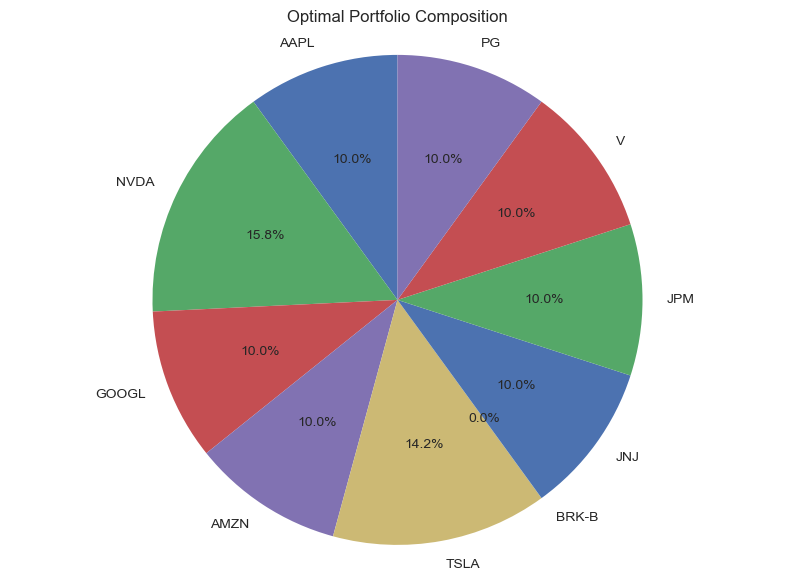

In [91]:
plt.style.use('seaborn')

# 1. Portfolio Composition Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(optimal_weights, labels=optimal_weights.index, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Composition')
plt.axis('equal')
plt.show()

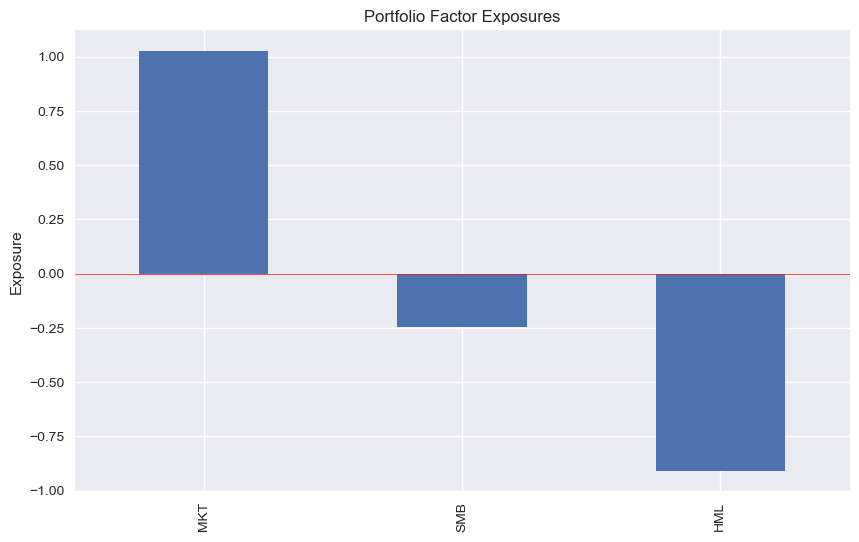

In [92]:
plt.figure(figsize=(10, 6))
factor_exposures.plot(kind='bar')
plt.title('Portfolio Factor Exposures')
plt.ylabel('Exposure')
plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
plt.show()

In [93]:
def portfolio_performance(weights):
    returns = np.sum(expected_returns_series * weights)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return np.array([returns, volatility])

In [94]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    results[0,i] = portfolio_performance(weights)[0]
    results[1,i] = portfolio_performance(weights)[1]
    results[2,i] = results[0,i] / results[1,i]

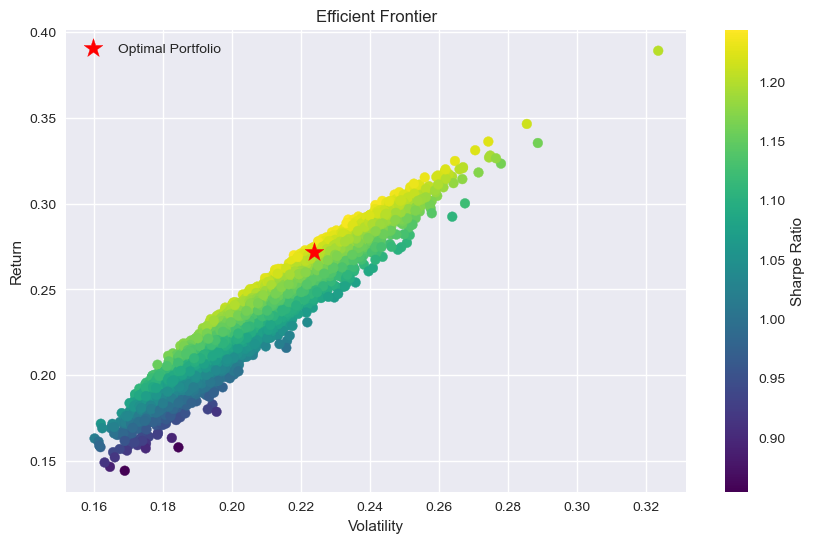

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.scatter(portfolio_volatility, portfolio_return, c='red', s=200, marker='*', label='Optimal Portfolio')
plt.legend()
plt.show()

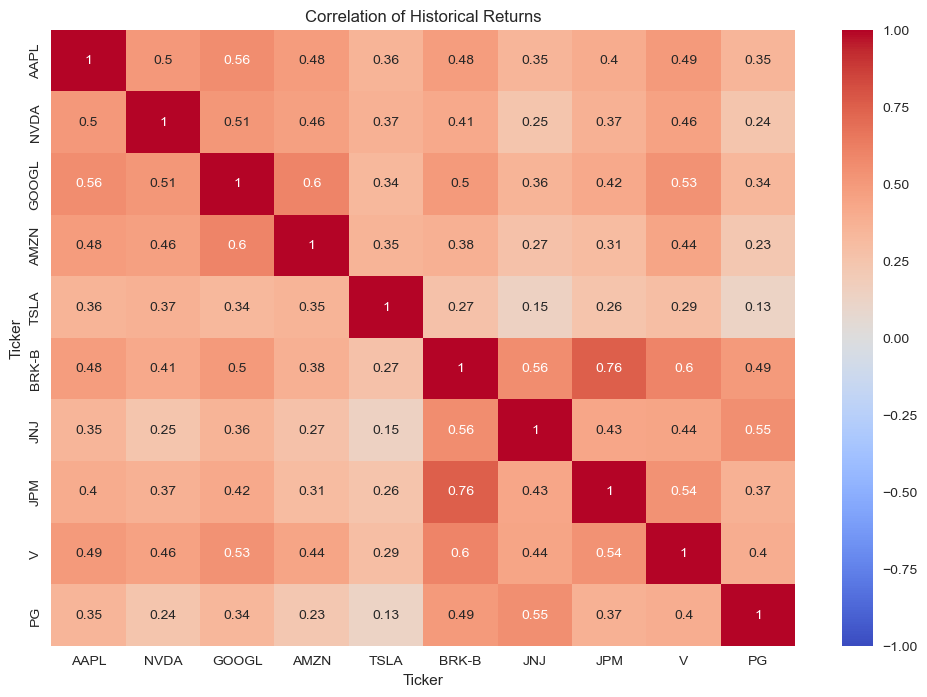

In [96]:
#Historical Returns Heatmap
import seaborn as sns
returns_data = returns[optimal_weights.index]
plt.figure(figsize=(12, 8))
sns.heatmap(returns_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Historical Returns')
plt.show()

**Correlation of Historical Returns (Heatmap):**

* Most correlations are positive, ranging from 0.13 to 0.8.
* Stocks like BRK-B and JPM show higher correlations with each other.
* TSLA shows lower correlations with most other stocks.

<Figure size 1200x600 with 0 Axes>

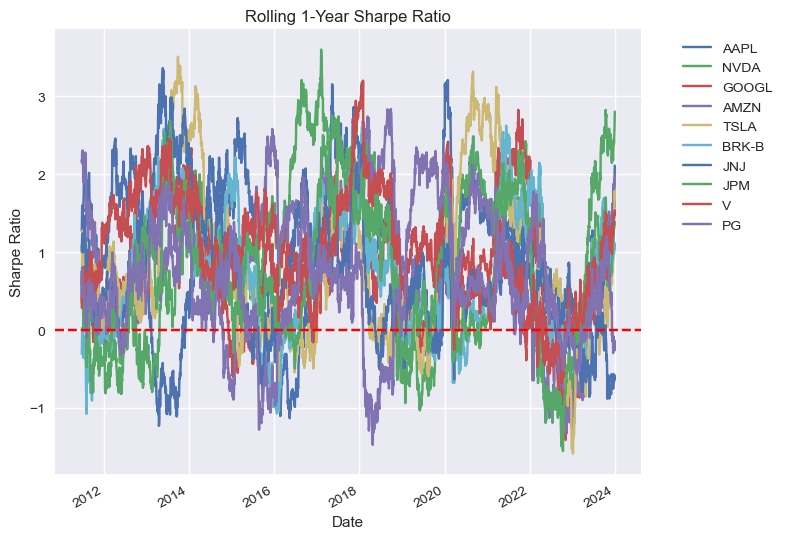

In [97]:
#Rolling Sharpe Ratio
rolling_returns = returns_data.rolling(window=252).mean() * 252
rolling_volatility = returns_data.rolling(window=252).std() * np.sqrt(252)
rolling_sharpe = (rolling_returns - 0.02) / rolling_volatility

plt.figure(figsize=(12, 6))
rolling_sharpe.plot()
plt.title('Rolling 1-Year Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Rolling 1-Year Sharpe Ratio:**
This line plot shows how the Sharpe ratio of each stock has changed over time:

* There's significant variation in Sharpe ratios over time for all stocks.
* Some stocks (NVDA, TSLA) show periods of very high Sharpe ratios.
* Most stocks experienced a sharp decline in Sharpe ratio around 2023, likely due to market conditions.

This plot highlights the dynamic nature of risk-adjusted returns and the importance of periodic portfolio rebalancing.

In [98]:
original_weights = pd.Series({
    'AAPL': 0.1783005,
    'NVDA': 0.2698478,
    'GOOGL': 0.0000000,
    'AMZN': 0.1354714,
    'TSLA': 0.1967270,
    'BRK-B': 0.0000000,
    'JNJ': 0.0314308,
    'JPM': 0.0000000,
    'V': 0.1882224,
    'PG': 0.0000000
})

In [99]:
comparison_df = pd.DataFrame({
    'Original': original_weights,
    'Constrained': optimal_weights
})

In [100]:
comparison_df = comparison_df.sort_values('Constrained', ascending=False)

<Figure size 1200x600 with 0 Axes>

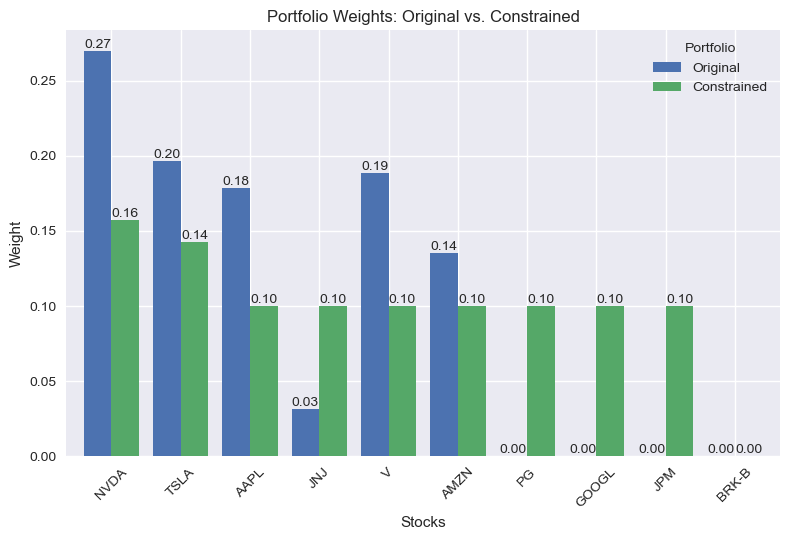

In [101]:
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', width=0.8)

plt.title('Portfolio Weights: Original vs. Constrained')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.legend(title='Portfolio')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels on the bars
for i in range(len(comparison_df)):
    for j in range(2):  # Two sets of bars
        value = comparison_df.iloc[i, j]
        plt.text(i + (j-0.5)*0.4, value, f'{value:.2f}', 
                 ha='center', va='bottom')

plt.show()

#### Thank you!